# Task
FER-2013 데이터셋을 다운로드하고 전처리하여 학습, 검증, 테스트 세트로 분할

데이터셋 로드 성공:


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training



감정 분포:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

DATA 분포:
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

샘플 이미지 시각화:


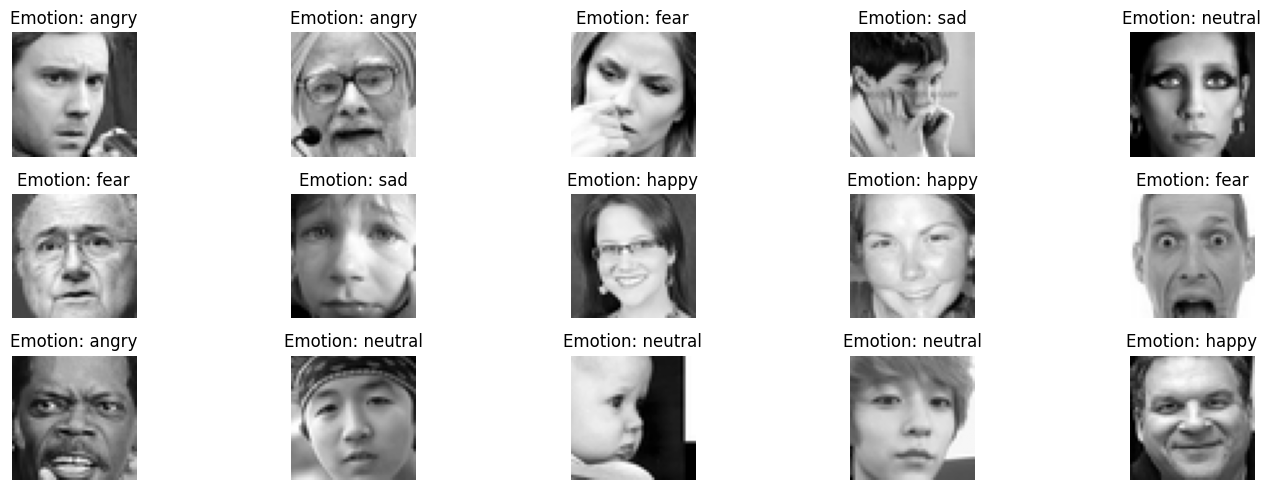

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


filepath = "/content/drive/MyDrive/data/fer2013.csv"

emotion_labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}


try:
    # Load the dataset
    df = pd.read_csv(filepath)
    print("데이터셋 로드 성공:")
    display(df.head(10))

    # Convert the pixel strings into numpy arrays
    df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split()).astype('float32'))

    # Let's see the distribution of emotions
    print("\n감정 분포:")
    print(df['emotion'].value_counts())

    print("\nDATA 분포:")
    print(df['Usage'].value_counts())


    # We can optionally visualize a few images
    print("\n샘플 이미지 시각화:")
    a, b = 3, 5 # Define a and b for subplot rows and columns
    fig, axes = plt.subplots(a, b, figsize=(15, 5))
    for i in range(a*b):
        pixels = df['pixels'].iloc[i].reshape(48, 48) # Assuming images are 48x48
        emotion_code = df['emotion'].iloc[i]
        emotion_name = emotion_labels.get(emotion_code, 'unknown') # Get emotion name using the mapping
        row_index = i // b # Calculate row index
        col_index = i % b # Calculate col index
        axes[row_index, col_index].imshow(pixels, cmap='gray') # Access subplot using row and column indices
        axes[row_index, col_index].set_title(f"Emotion: {emotion_name}") # Use emotion name in the title
        axes[row_index, col_index].axis('off')
    plt.tight_layout() # Adjust layout to prevent titles overlapping
    plt.show()

except FileNotFoundError:
    print(f"오류: '{filepath}' 파일을 찾을 수 없습니다. 파일을 업로드했는지 확인해주세요.")
except Exception as e:
    print(f"데이터 로드 또는 전처리 중 오류 발생: {e}")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split # random_split은 더 이상 사용하지 않지만 임포트는 유지
import numpy as np
import pandas as pd
from torchvision import transforms

# Custom Dataset Class for FER2013
class FER2013Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Reshape pixels to image format (48x48) and convert to PIL Image for transforms
        # Assuming pixels are already a numpy array of floats from previous step
        # Make sure pixels are treated as a numpy array before reshaping
        if isinstance(pixels, list):
             pixels = np.array(pixels)

        image = pixels.reshape(48, 48).astype(np.uint8) # Convert to uint8 for PIL Image
        image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)

        # Return image as a PyTorch tensor and emotion as a tensor
        return image, torch.tensor(emotion, dtype=torch.long)

# Assuming df is available from the previous step and contains the loaded data
# Define transforms (e.g., normalization)
# You might want to add more transforms for data augmentation during training
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image to PyTorch Tensor (scales to [0, 1])
    # Add more transforms here if needed, e.g., transforms.Normalize(...)
])

# Filter dataframes based on 'Usage' column
train_df = df[df['Usage'] == 'Training'].reset_index(drop=True)
val_df = df[df['Usage'] == 'PublicTest'].reset_index(drop=True)
test_df = df[df['Usage'] == 'PrivateTest'].reset_index(drop=True)


# Create datasets for each split
train_dataset = FER2013Dataset(train_df, transform=transform)
val_dataset = FER2013Dataset(val_df, transform=transform)
test_dataset = FER2013Dataset(test_df, transform=transform)


print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders (optional, but recommended for batching and shuffling)
# You can adjust batch_size as needed
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\n데이터 로딩 및 분할 완료 (PyTorch):")
print(f"학습 데이터로더 배치 수: {len(train_loader)}")
print(f"검증 데이터로더 배치 수: {len(val_loader)}")
print(f"테스트 데이터로더 배치 수: {len(test_loader)}")

# Example of how to get a batch
# images, labels = next(iter(train_loader))
# print("\n학습 데이터 배치 형태 (이미지, 레이블):", images.shape, labels.shape)

Training set size: 28709
Validation set size: 3589
Test set size: 3589

데이터 로딩 및 분할 완료 (PyTorch):
학습 데이터로더 배치 수: 449
검증 데이터로더 배치 수: 57
테스트 데이터로더 배치 수: 57


In [ ]:
import os

filepath = "fer2013.csv"
print(os.path.abspath(filepath))

/content/fer2013.csv
